In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import lit, last_day, col, array, explode, struct, udf, to_date, month, year, sum as spark_sum

In [2]:
spark = SparkSession.builder.appName('Rank_Mean').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Rank_Mean>

In [3]:
## por temas de replicación, siempre es mejor convertir el archivo a leer en formato csv

monthly_data = spark.read.parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")
index_vector = spark.read.csv("data/raw/csv/unique_dateprice_vector.csv", header=True, inferSchema=True)

In [4]:
from datetime import datetime

def datetime_object(datetime_str):
    print(datetime_str)
    datetime_object = datetime.strptime(datetime_str, '%d/%m/%y').date()
    return datetime_object

datetime_object_udf = udf(f=datetime_object, returnType=DateType())

In [5]:
index_vector_schema = index_vector.select("MXWDU_Index", datetime_object_udf(col("operation_date")).alias('operation_date'))
index_vector_schema.show(5, False)

+-----------+--------------+
|MXWDU_Index|operation_date|
+-----------+--------------+
|51.12      |2016-01-01    |
|54.830002  |2016-01-04    |
|54.880001  |2016-01-05    |
|54.049999  |2016-01-06    |
|52.790001  |2016-01-07    |
+-----------+--------------+
only showing top 5 rows



In [6]:
close_date_index = index_vector_schema.select("*", last_day(col("operation_date")).alias("close_date"))\
                                      .where(col("operation_date") == col("close_date")).orderBy(col("operation_date"))\
                                      .drop("close_date")
close_date_index.show(5, False)

+-----------+--------------+
|MXWDU_Index|operation_date|
+-----------+--------------+
|52.200001  |2016-02-29    |
|56.060001  |2016-03-31    |
|57.0       |2016-05-31    |
|56.23      |2016-06-30    |
|58.549999  |2016-08-31    |
+-----------+--------------+
only showing top 5 rows



In [7]:
monthly_portfolio = monthly_data.select("*", last_day(col("operation_date")).alias("close_date"))\
                                .where(col("operation_date") == col("close_date")).drop("close_date")\
                                .orderBy("operation_date")

In [8]:
index_portfolio_df = monthly_portfolio.join(close_date_index, on="operation_date", how="inner")
index_portfolio_df.show(5, False)

+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+---------+--------+--------+--------+--------+--------+---------+--------+--------+---------+--------+--------+--------+--------+---------+--------+---------+---------+--------+---------+--------+--------+--------+--------+-------+--------+---------+--------+---------+--------+----------+--------+----------+---------+--------+----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----------+----------+----------+----------+--------+----------+----------+----------+----------+---------+---------+--------+--------+-

In [9]:
monthly_data = index_portfolio_df.toPandas()
print("nuestros datos:", monthly_data.shape)

nuestros datos: (31, 214)


In [10]:
## seleccionamos la primera columna y lo convertimos a vector, esta columna representa el indice que estamos analizando, 
## 'MXWDU_Index', la idea es medir esta columna con el resto, ya que las demás son acciones que forman parte de ése índice.

benchmark_month = monthly_data["MXWDU_Index"]

# nuestros datos
print(benchmark_month.shape)
benchmark_month

(31,)


0     52.200001
1     56.060001
2     57.000000
3     56.230000
4     58.549999
5     59.099998
6     57.970001
7     58.570000
8     60.889999
9     62.419998
10    63.259998
11    65.699997
12    65.489998
13    67.279999
14    67.550003
15    70.300003
16    71.720001
17    76.199997
18    72.790001
19    71.989998
20    72.330002
21    73.300003
22    73.809998
23    68.739998
24    69.830002
25    64.160004
26    69.320000
27    71.029999
28    74.620003
29    70.089996
30    73.760002
Name: MXWDU_Index, dtype: float64

In [11]:
## Calculamos el porcentaje de cambio de un día contra otro.
## fórmula: (t+1 / t)-1
## pseudo-código: (precio_hoy / precio_ayer)-1

pct_benchmark_month = benchmark_month.pct_change(1)
print(pct_benchmark_month.shape)

# nuestros datos
pct_benchmark_month

(31,)


0          NaN
1     0.073946
2     0.016768
3    -0.013509
4     0.041259
5     0.009394
6    -0.019120
7     0.010350
8     0.039611
9     0.025127
10    0.013457
11    0.038571
12   -0.003196
13    0.027332
14    0.004013
15    0.040711
16    0.020199
17    0.062465
18   -0.044751
19   -0.010991
20    0.004723
21    0.013411
22    0.006958
23   -0.068690
24    0.015857
25   -0.081197
26    0.080424
27    0.024668
28    0.050542
29   -0.060708
30    0.052361
Name: MXWDU_Index, dtype: float64

In [12]:
## el vector de "percentage change" se convierte a un arreglo numpy de dimensión (147,)
## NOTA: en los arreglos (objetos) de tipo numpy.array preservan los valores, tanto por fila, como por columna,
##       el órden de los elementos, cómo un 'índice implícito'

pct_benchmark_month_array = np.array(pct_benchmark_month)
print(pct_benchmark_month_array.shape)
pct_benchmark_month_array

(31,)


array([        nan,  0.07394636,  0.01676773, -0.01350877,  0.0412591 ,
        0.00939366, -0.01912009,  0.01035016,  0.03961071,  0.02512726,
        0.01345723,  0.03857096, -0.00319633,  0.02733243,  0.00401314,
        0.04071058,  0.02019912,  0.06246509, -0.04475061, -0.01099056,
        0.00472293,  0.01341077,  0.00695764, -0.06868988,  0.01585691,
       -0.08119716,  0.08042387,  0.02466819,  0.05054208, -0.06070768,
        0.05236134])

In [13]:
## Lo mismo hacemos, pero para el resto de variables equity,
## seleccionamos la primera columna y lo convertimos a vector, esta columna representa el indice que estamos analizando, 
## 'MXWDU_Index', la idea es medir esta columna con el resto, ya que las demás son acciones que forman parte de ese índice.

investment_universe_month = monthly_data.drop(['operation_id', "operation_date", "MXWDU_Index"], axis = 1)

# nuestros datos
investment_universe_month.shape

(31, 211)

In [14]:
## (t+1 / t)-1
## (precio_hoy / precio_ayer)-1

pct_investment_month = investment_universe_month.pct_change(1)

# nuestros datos
pct_investment_month.shape

(31, 211)

In [15]:
## el vector de percentage change se convierte a un arreglo numpy de dimensión (147,70)

pct_investment_month_array = np.array(pct_investment_month)
#_pct_investment_month_array = np.array(_pct_investment_month)

# nuestros datos
print(pct_investment_month_array.shape)

(31, 211)


In [16]:
## creamos arreglos numpy con dimensiones X+1 = 148, rellenas de ceros, para ser imputados con nuevos vectores

up_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
down_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
up_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))
down_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))

print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(32, 1)
(32, 1)
(32, 211)
(32, 211)


In [17]:
## rellenamos las matrices de ceros con valores que aprueben las condiciones, 
## se realiza una comparación dentro de los arreglos de porcentajes de cambio, 
## sí alguno de esos porcentajes es superior a 0, entonces entra a los arreglos 
## de movimientos positivos (incrementos), pero sí alguno es menor que 0, entonces
## el porcentaje se almacena en los arreglos de movimientos negativos (decrementos).

## Básicamente, se separan los porcentajes de cambio en dos matrices: 
## matriz de positivos cuando el porcentaje es > 0 
## matriz de negativos cuando el porcentaje es <= 0

size_benchmark_matrix = pct_benchmark_month_array.shape[0]
for i in range (1, size_benchmark_matrix):
    if pct_benchmark_month_array[i] > 0:
        up_month[i] = pct_benchmark_month_array[i]
        up_move[i] = pct_investment_month_array[i, 0:pct_investment_month_array.shape[1]]
    else:
        down_month[i] = pct_benchmark_month_array[i]
        down_move[i] = pct_investment_month_array[i, 0:pct_investment_month_array.shape[1]]

In [18]:
## calculamos los vectores 'peor más alto' y 'mejor más alto'

np.seterr(divide='ignore', invalid='ignore')
greater_worse = down_move / down_month
greater_better = (up_move / up_month) * float(-1.0)

print(greater_worse.shape)
print(greater_better.shape)

(32, 211)
(32, 211)


In [19]:
## ambos vectores los convertimos a pandas dataframes, y solo nos quedamos con los vectores que tengan valores != np.nan
## una de las ventajas de los pandas dataframes es que mantienen un ídince único por row, esto lo hace poder separarse, y juntarse
## en cuantos sub-conjuntos se requieran y siempre se podrá mantener un órden.

greater_worse_df = pd.DataFrame(data=greater_worse).dropna()
greater_better_df = pd.DataFrame(data=greater_better).dropna()

print(greater_worse_df.shape)
print(greater_better_df.shape)

(8, 211)
(22, 211)


In [20]:
## calculamos ahora, la mediana acumulada con los pandas dataframes que construimos, 
## con un periodo mínimo (método expanding) de al menos 1 observación dada.

median_down = greater_worse_df.expanding().median()
median_up = greater_better_df.expanding().median()

print(median_down.shape)
print(median_up.shape)

(8, 211)
(22, 211)


In [21]:
# se transponen ambos pandas df por la columna periodos, columna que almacena números no consecutivos desde 1 hasta 147

down_transpose = median_down.T
up_transpose = median_up.T

print(down_transpose.shape)
print(up_transpose.shape)

(211, 8)
(211, 22)


In [22]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_down

ranked_down = down_transpose.rank(method='first')
transpose_ranked_down = ranked_down.T

print(ranked_down.shape)
print(transpose_ranked_down.shape)

(211, 8)
(8, 211)


In [23]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_up

ranked_up = up_transpose.rank(method='first')
transpose_ranked_up = ranked_up.T

print(ranked_up.shape)
print(transpose_ranked_up.shape)

(211, 22)
(22, 211)


In [24]:
## se añade variable 'label' con la idea de que al juntar ambos dataframes se puedan distinguir los 'worse' de los 'better'
## y se unen ambos dataframes con la etiqueta creada, se usó el método 'insert' por lo que no se deberá correr de nuevo, una
## vez ejecutado ya que fallará por duplicidad de columnas.

worse_better_df = pd.concat([transpose_ranked_up, transpose_ranked_down]).sort_index()
worse_better_df.shape

(30, 211)

In [25]:
## se crea un índice 'closing_id' para cada registro, éste corre de [1:N] 
## con la idea de etiquetar el id del mes de registro de cierre,
## de la misma forma que lo anterior, NO se deberá ejecutar de nuevo; una vez hecho.

worse_better_df['closing_id'] = range(1, len(worse_better_df) + 1)
worse_better_df.shape

(30, 212)

In [26]:
## se transponen ambos dataframes, de antes tener una dimensión (68, 70), es decir; 
## 68 registros i.e. 'Rows' (variables)
## 70 columnas fijas (a menos que sea añadido otro asset desde el csv inicial)

## a tener una dimensión 'transpuesta' (invertída sí querés...) de (70, 68), es decir;
## 70 registros i.e. 'Rows' fijos (a menos que sea añadido otro asset desde el csv inicial)
## 68 columnas (variables!!!)

In [27]:
## de pandas dataframes, una vez separados en dos conjuntos ['worse', 'better'],
## creamos por separado dos spark dataframes.

worse_better = spark.createDataFrame(worse_better_df)
worse_better.show(5, False)

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+

In [28]:
## se crea un generador "shape long format", una lista con iteraciones, esta lista trabajará con dos variables principales,
## 1-. la variable 'equity_index', será la que contenga los 'id' de los activos
## 2-. la variable 'median_down', será la que contenga la mediana acumulada por cada activo.
## Se mantendrá a lo largo de la transformación 1 columna fija; 'closing_id',
## closing_id: variable que indica el mes de cierre y reporte de precio

def panel_format(df, pivot_col, new_columns: list = []):
    first_col = str(new_columns[0])
    second_col = str(new_columns[1])
    piv_col = [pivot_col]
    df_types = df.dtypes
    cols, dtype = zip(*((c, t) for (c, t) in df_types if c not in piv_col))
    if len(set(dtype)) == 1:
        ValueError("Columns not the same data type...")
    generator_explode = explode(array([
        struct(lit(c).alias(first_col), col(c).alias(second_col)) for c in cols
    ])).alias("column_explode")
    column_to_explode = ["column_explode."+first_col, "column_explode."+second_col]
    panel_df = df.select(piv_col + [generator_explode])\
                 .select(piv_col + column_to_explode)
    return panel_df

In [29]:
## se crea nuevo spark-dataframe donde solo se mostrará por partición ['closing_id'] 
## el top 10 mejores meses donde tuvo menos malos que el resto de los registros; ["top_rank"].
new_columns = ["asset_id", "rank"]
asset_ranking_df = panel_format(worse_better, "closing_id", new_columns)
asset_ranking_df.show(5, False)

+----------+--------+-----+
|closing_id|asset_id|rank |
+----------+--------+-----+
|1         |0       |141.0|
|1         |1       |182.0|
|1         |2       |140.0|
|1         |3       |118.0|
|1         |4       |171.0|
+----------+--------+-----+
only showing top 5 rows



In [30]:
asset_rank_10 = asset_ranking_df.where(col("rank") <= 10).orderBy("closing_id", "rank").toPandas()

# A partir de aqui se escribe en formato csv para trabajar con Pandas

In [31]:
## lo que se pretende ahora, es obtener una matriz de dimensión (146, 10), es decir, 
## tener en cada row las fechas de cierre [closing_id],
## en cada columna (header) el número de ranking top 10 [top_rank],
## y en cada campo, el id del activo [asset_id].

pandas_df = asset_rank_10.astype({'asset_id':'int32'})
newselect = asset_rank_10[["closing_id", "asset_id"]]
num_of_assets = 10

indexed = np.zeros((investment_universe_month.shape[0], num_of_assets))

for q in range(1,investment_universe_month.shape[0]):
    selection = newselect.loc[pandas_df["closing_id"]==q]
    newselect_transpose = selection.T
    newpdf = newselect_transpose['asset_id':].head()
    indexed[q] = newpdf

In [32]:
indexed = indexed[1:investment_universe_month.shape[0]+1]
index_row = indexed.astype(np.int64)
newrow = [0]*num_of_assets #np.zeros((1,num_of_assets))
index_row = np.vstack([index_row,newrow])
portfolio = np.zeros((investment_universe_month.shape[0], num_of_assets))

for r in range(0,investment_universe_month.shape[0]-1):
    s = r+1
    columns = index_row[s]
    portfolio[s] = pct_investment_month_array[s,[columns]]

In [33]:
means = portfolio[1:investment_universe_month.shape[0]-1]
performance = np.dot(portfolio,(1/num_of_assets))
returns = np.zeros((investment_universe_month.shape[0]-1,1))
equalw = np.zeros((investment_universe_month.shape[0]-1,1))
eweights = 1/(pct_investment_month_array.shape[1])
eweighted = np.dot(pct_investment_month_array,eweights)

for x in range (1,investment_universe_month.shape[0]):
    returns[x-1] = sum(performance[x])
    equalw[x-1] = sum(eweighted[x])

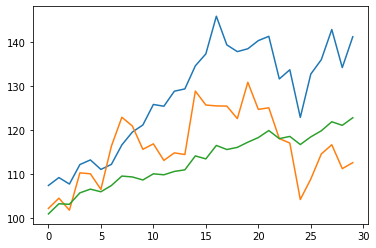

In [34]:
beg = 100
start = 100
commence = 100
bench = pct_benchmark_month_array[1:investment_universe_month.shape[0]]
bmk = np.zeros((investment_universe_month.shape[0],))
port = np.zeros((investment_universe_month.shape[0]-1,))
ew = np.zeros((investment_universe_month.shape[0]-1,))

for i in range (0,investment_universe_month.shape[0]-1):
    bmk[i] = beg*(1+bench[i])
    beg = bmk[i]
    port[i] = start*(1+returns[i])
    start = port[i]
    ew[i] = commence*(1+equalw[i])
    commence = ew[i]

plt.plot(bmk[0:investment_universe_month.shape[0]-1])
plt.plot(port)
plt.plot(ew)

In [35]:
input_assets = index_row[index_row.shape[0]-2]
input_assets1 = pct_investment_month_array[:, input_assets]
dataframe = pd.DataFrame(input_assets1)
input_assets1 = dataframe.dropna()
mean_returns = input_assets1.mean()
covar_matrix = input_assets1.cov()
tickers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 12
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

In [36]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio

        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T, columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])

    return results_df

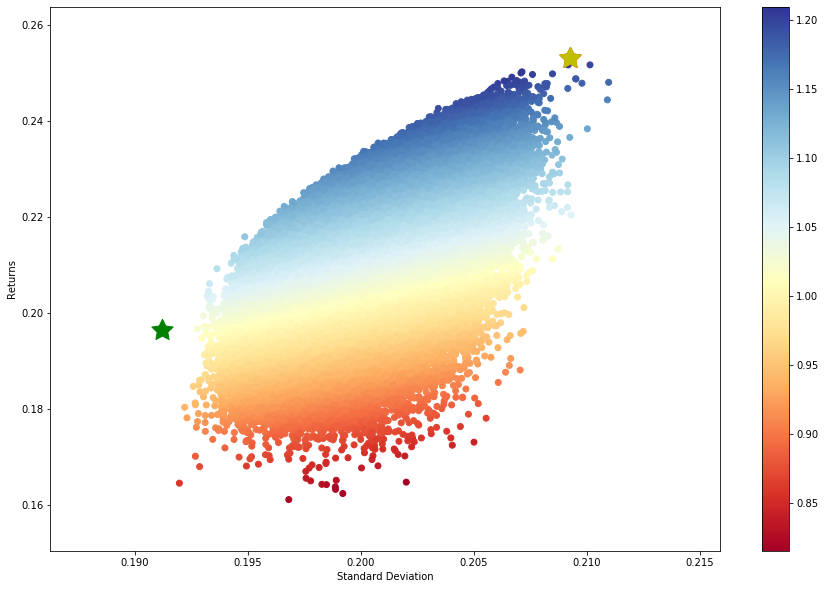

In [37]:
# TODO: revisar la sobrecarga de memoria en los stages marcados

mean_returns = input_assets1.mean()
cov = input_assets1.cov()
num_portfolios = 1000000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

max_return_port = results_frame.iloc[results_frame['ret'].idxmax()]

plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5,1,0), color='r', s=500)
plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5,1,0), color='g', s=500)
plt.scatter(max_return_port['stdev'], max_return_port['ret'], marker=(5,1,0), color='y', s=500)
plt.show()

In [80]:
def pd_series_to_dict(pd_series):
    return dict(pd_series)

In [81]:
pd_series_to_dict(min_vol_port)

{'ret': 0.19647443977674306,
 'stdev': 0.19119096984884199,
 'sharpe': 1.0276345160656817,
 0: 0.05225136646873044,
 1: 0.05243674015371823,
 2: 0.029532311465484386,
 3: 0.031214094363762934,
 4: 0.0038932142281170416,
 5: 0.26857674711005236,
 6: 0.0011404182976629004,
 7: 0.4922516626585827,
 8: 0.06536871550703524,
 9: 0.003334729746853719}

In [59]:
renamed_columns = {
    0: 'fund_w_zero',
    1: 'fund_w_one',
    2: 'fund_w_two',
    3: 'fund_w_three',
    4: 'fund_w_four',
    5: 'fund_w_five',
    6: 'fund_w_six',
    7: 'fund_w_seven',
    8: 'fund_w_eight',
    9: 'fund_w_nine'
}
results_frame_renamed = results_frame.rename(columns=renamed_columns)

In [60]:
from pyspark.sql.types import *

# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return DateType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types):
        struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return spark.createDataFrame(pandas_df, p_schema)

In [61]:
results_spark_df = pandas_to_spark(results_frame_renamed)
results_spark_df.show(5, False)

+----------+----------+---------+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+------------+-----------+
|ret       |stdev     |sharpe   |fund_w_zero|fund_w_one |fund_w_two |fund_w_three|fund_w_four|fund_w_five|fund_w_six |fund_w_seven|fund_w_eight|fund_w_nine|
+----------+----------+---------+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+------------+-----------+
|0.20653518|0.20292516|1.0177898|0.13552734 |0.18037042 |0.19299962 |0.111815155 |0.025592843|0.04308156 |0.107848875|0.034010552 |0.16274895  |0.006004678|
|0.21832877|0.20044951|1.0891958|0.031794157|0.14382409 |0.16916172 |0.08626087  |0.030922035|0.16874908 |0.010078558|0.08327981  |0.09044561  |0.18548407 |
|0.20926592|0.19892733|1.0519717|0.023925329|0.052384797|0.014998284|0.13152312  |0.19947197 |0.07284325 |0.067116655|0.103329174 |0.14966087  |0.18474655 |
|0.19584754|0.1984434 |0.9869189|0.1073277  |0.103270754|0

In [62]:
from pyspark.sql.functions import monotonically_increasing_id 

results_index = results_spark_df.select("*", monotonically_increasing_id().alias("id"))
results_index.show(5, False)

+----------+----------+---------+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+------------+-----------+---+
|ret       |stdev     |sharpe   |fund_w_zero|fund_w_one |fund_w_two |fund_w_three|fund_w_four|fund_w_five|fund_w_six |fund_w_seven|fund_w_eight|fund_w_nine|id |
+----------+----------+---------+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+------------+-----------+---+
|0.20653518|0.20292516|1.0177898|0.13552734 |0.18037042 |0.19299962 |0.111815155 |0.025592843|0.04308156 |0.107848875|0.034010552 |0.16274895  |0.006004678|0  |
|0.21832877|0.20044951|1.0891958|0.031794157|0.14382409 |0.16916172 |0.08626087  |0.030922035|0.16874908 |0.010078558|0.08327981  |0.09044561  |0.18548407 |1  |
|0.20926592|0.19892733|1.0519717|0.023925329|0.052384797|0.014998284|0.13152312  |0.19947197 |0.07284325 |0.067116655|0.103329174 |0.14966087  |0.18474655 |2  |
|0.19584754|0.1984434 |0.9869189|0

In [ ]:
AggresiveDF = results_index.where(col("fund_w_zero") <= .04)
ModerateAggresiveDF

+----------+----------+---------+------------+------------+----------+------------+------------+------------+-----------+------------+------------+-----------+-----------+
|ret       |stdev     |sharpe   |fund_w_zero |fund_w_one  |fund_w_two|fund_w_three|fund_w_four |fund_w_five |fund_w_six |fund_w_seven|fund_w_eight|fund_w_nine|id         |
+----------+----------+---------+------------+------------+----------+------------+------------+------------+-----------+------------+------------+-----------+-----------+
|0.25309223|0.20926106|1.2094569|0.017588442 |0.062877096 |0.33016258|0.33498204  |0.02894998  |0.0057056025|0.082054034|0.05622855  |0.012438027 |0.06901365 |42949737782|
|0.2502965 |0.20713261|1.2083879|0.03655791  |0.0030214626|0.34322488|0.2183391   |0.101994745 |0.017222201 |0.18388873 |0.04943643  |0.0032544867|0.043060064|25769860456|
|0.2500531 |0.20708653|1.2074813|0.0075049307|0.059862006 |0.25569266|0.25423142  |0.11699037  |0.07104376  |0.10980567 |0.0042839916|0.0010

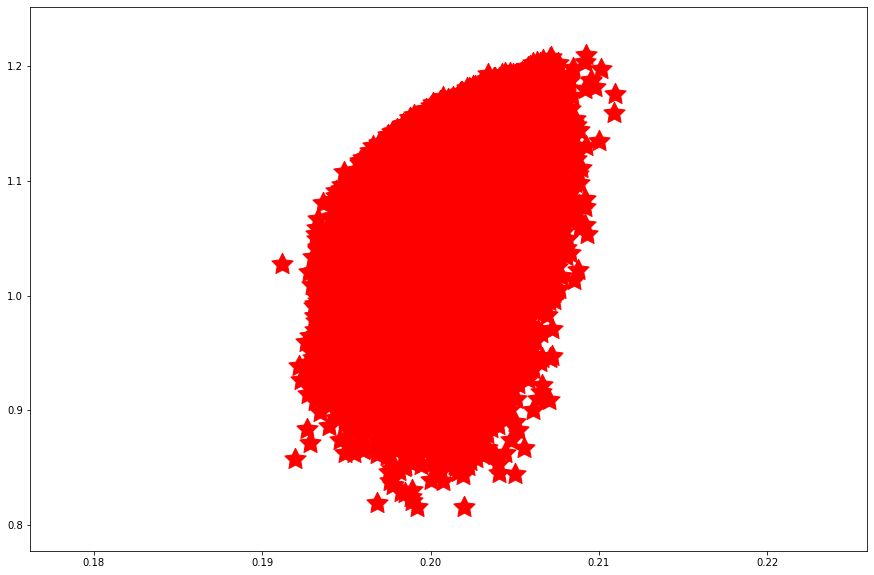

In [63]:
# testing

# cual es el mejor port con base en el sharpe para cada cliente

sorted_results = results_index.orderBy(col("sharpe").desc())
sorted_results.show(10, False)
pd_results = sorted_results.toPandas()
plt.subplots(figsize=(15,10))
plt.scatter(pd_results['stdev'], pd_results['sharpe'], marker=(5,1,0), color='r', s=500)
plt.show()

opt_results:      fun: -1.2619535608064174
     jac: array([3.14231098e-01, 1.96661204e-01, 1.49011612e-08, 1.49011612e-08,
       6.22626245e-02, 5.02374917e-02, 5.02374917e-02, 1.56035349e-01,
       6.72335044e-01, 6.11471683e-02])
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.87613737e-17, 0.00000000e+00, 5.00000000e-01, 5.00000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.01324967e-17,
       4.28397752e-16, 0.00000000e+00])


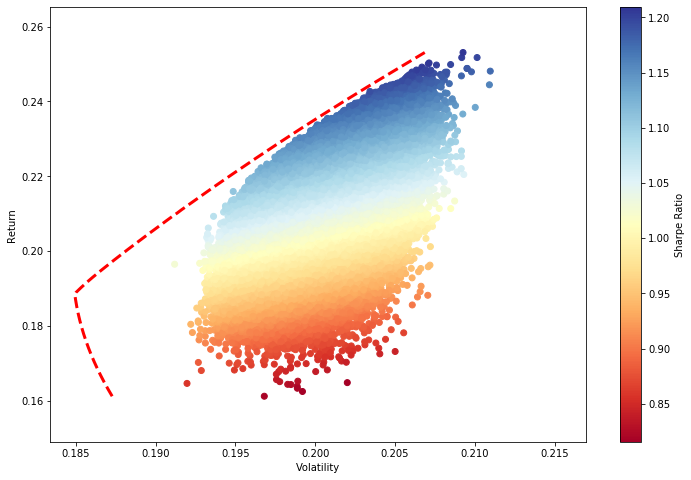

In [43]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(mean_returns * weights) * 12
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
init_guess = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
opt_results = sco.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print("opt_results:", opt_results)

get_ret_vol_sr(opt_results.x)

vol_arr = results_frame.stdev
ret_arr = results_frame.ret
sharpe_arr = results_frame.sharpe

range_vol_min = min(vol_arr)
range_vol_max = max(vol_arr)
range_ret_min = min(ret_arr)
range_ret_max = max(ret_arr)
range_sharpe_min = min(sharpe_arr)
range_sharpe_max = max(sharpe_arr)

frontier_y = np.linspace(range_ret_min, range_ret_max, 200)
frontier_x = []


def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = sco.minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])


# cmap='RdYlBu' 

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='RdYlBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
# plt.savefig('cover.png')
plt.show()